This is an updated and expanded version of an [old blog post](https://rdkit.blogspot.com/2019/11/constructing-sar-tables-in-jupyter.html).

This one was inspired by a thread on the [rdkit-discuss](https://sourceforge.net/projects/rdkit/lists/rdkit-discuss) mailing list: https://www.mail-archive.com/rdkit-discuss@lists.sourceforge.net/msg09068.html

An SAR table is often a convenient way to summarize a dataset. These compact views of an SAR dataset have R1 structures in the rows, R2 structures in the columns, and measured values in the cells. I guess you probably know what I'm talking about even if I'm not describing it particularly well; if not, scroll down a bit and you'll see one. :-)

The question on the mailing list was how to build one of these with the RDKit and display it in Jupyter. That's what we'll do in this blog post.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdDepictor
import rdkit
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames()

import time
print(rdkit.__version__)
print(time.ctime())

2024.09.6
Sat Mar 15 06:00:22 2025


# Read in our dataset

This is data from ChEMBL for a set of compounds with EC50 values measured against S1P1.

In [2]:
!head ../data/S1P1_data.csv

"doc_id","molregno","standard_relation","standard_value","standard_units","standard_flag","standard_type","pchembl_value","canonical_smiles","compound_chembl_id"
5839,189018,"=",82,"nM",1,"EC50",7.09,"CCCCCCCCc1ccc(NC(=O)[C@@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F","CHEMBL332050"
5839,188442,"=",322.1,"nM",1,"EC50",6.49,"CCCCCCCCCCCCCCONC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F","CHEMBL115505"
5839,188375,"=",260,"nM",1,"EC50",6.58,"CCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F","CHEMBL115344"
5839,188376,"=",598.4,"nM",1,"EC50",6.22,"CCCCCCCCCCCCNC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F","CHEMBL324358"
5839,188766,"=",12.7,"nM",1,"EC50",7.9,"CCCCCCCCCCCCCCNC(=O)[C@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F","CHEMBL332472"
5839,188278,"=",58,"nM",1,"EC50",7.24,"CCCCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F","CHEMBL422074"
5839,188644,"=",130,"nM",1,"EC50",6.89,"CCCCCCCCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F","CHEMBL116953"
5839,188322,"=",8.6,"nM",1,"EC50",8.07,

,doc_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,pchembl_value,canonical_smiles,compound_chembl_id,ROMol
0,5839,189018,=,82.0,nM,1,EC50,7.09,CCCCCCCCc1ccc(NC(=O)[C@@H](N)COP(=O)(O)O)cc1.O...,CHEMBL332050,
1,5839,188442,=,322.1,nM,1,EC50,6.49,CCCCCCCCCCCCCCONC(=O)[C@@H](N)COP(=O)(O)O.OC(=...,CHEMBL115505,
2,5839,188375,=,260.0,nM,1,EC50,6.58,CCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=...,CHEMBL115344,
3,5839,188376,=,598.4,nM,1,EC50,6.22,CCCCCCCCCCCCNC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C...,CHEMBL324358,
4,5839,188766,=,12.7,nM,1,EC50,7.90,CCCCCCCCCCCCCCNC(=O)[C@H](N)COP(=O)(O)O.OC(=O)...,CHEMBL332472,

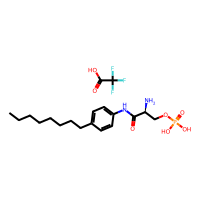
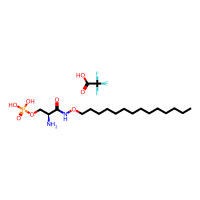
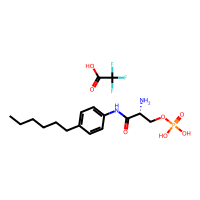
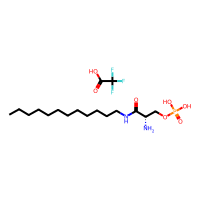
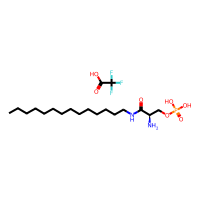

In [3]:
df = pd.read_csv('../data/S1P1_data.csv')
PandasTools.AddMoleculeColumnToFrame(df,smilesCol='canonical_smiles')
df.head()

# Do the R-group decomposition to get something to work with

For the demo here I'm going to use the structures from [this paper](https://pubs.acs.org/doi/abs/10.1021/jm5010336), which is in ChEMBL as [CHEMBL3352346](https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3352346/).

To get the data in the form we need, we start with an R-group decomposition. This is another one of those topics where I need to do a blog post and/or write more documentation... fortunately, we're just doing the basics here:

,Mol,R1,R2
0,,,
1,,,
2,,,
3,,,
4,,,

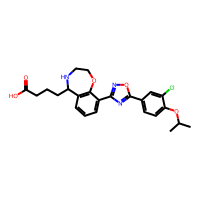
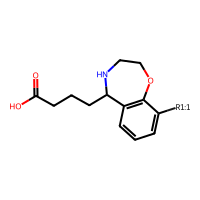
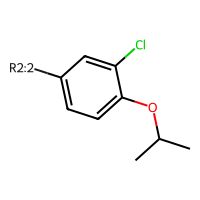
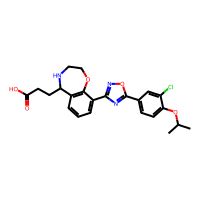
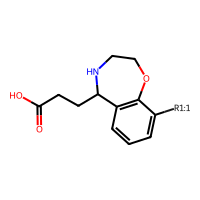
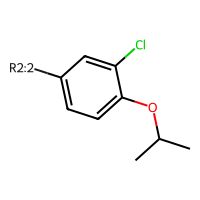
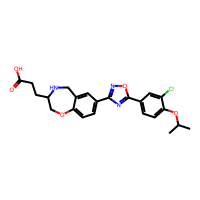
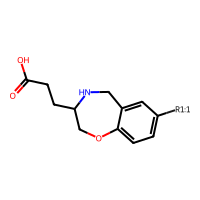
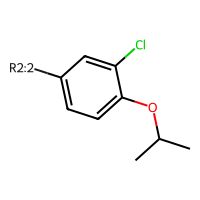
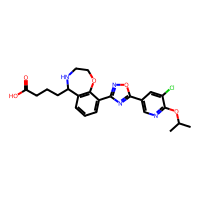
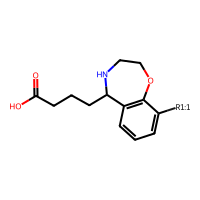
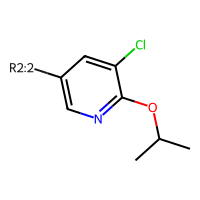
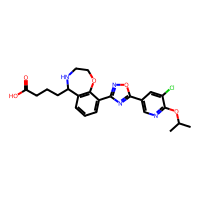
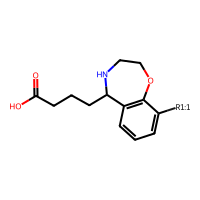
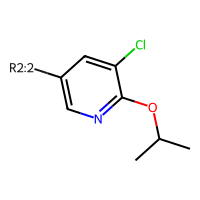

In [4]:
# we need to provide a scaffold to use for the r-group decomposition:
doc_scaffold = Chem.MolFromSmarts('[*:1]c1nc([*:2])on1')

# filter the data to just include the rows from our document:
doc_id = 89753
docdf = df[df.doc_id==doc_id]

# align all the molecules to the scaffold:
rdDepictor.Compute2DCoords(doc_scaffold)
for m in docdf.ROMol:
    rdDepictor.GenerateDepictionMatching2DStructure(m,doc_scaffold)

# do an r-group decomposition:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([doc_scaffold],docdf.ROMol,asSmiles=False,asRows=False) 

# and look at the results:
ms = [y for x,y in enumerate(docdf.ROMol) if x not in unmatched]
#res = groups_to_df(groups,ms,include_core=False)
res = PandasTools.RGroupDecompositionToFrame(groups,ms,include_core=False)
res.head()

For the purposes of this analysis, it's quicker/easier to get the data from the RGD code in a different format:

In [5]:
groups,unmatched = rdRGroupDecomposition.RGroupDecompose([doc_scaffold],docdf.ROMol,asSmiles=False,asRows=False) 

This next block defines the function that actually creates the SAR matrix as HTML

In [6]:
from collections import Counter
from IPython.display import HTML
import base64
def mol_to_img(m):
    dm = Draw.PrepareMolForDrawing(m)
    d2d = Draw.MolDraw2DCairo(250,200)
    dopts = d2d.drawOptions()
    dopts.dummiesAreAttachments=True
    d2d.DrawMolecule(dm)
    d2d.FinishDrawing()
    png_data = d2d.GetDrawingText() 
    png_data = base64.encodebytes(png_data)
    html ='<img src="data:image/png;base64,%s">'%png_data.decode()
    return html

def run_groups(groups,unmatched,mols,values,r1_label='R1',r2_label='R2',threshold=1):
    # generate SAR matrix
    
    # generate SMILES for each of the R-groups and map those 
    # to the R-group's molecule objects:
    r1_smiles = [Chem.MolToSmiles(x) for x in groups[r1_label]]
    r2_smiles = [Chem.MolToSmiles(x) for x in groups[r2_label]]
    r1_lookup = dict(zip(r1_smiles,groups[r1_label]))
    r2_lookup = dict(zip(r2_smiles,groups[r2_label]))
    
    # all_r1s and all_r2s map R indices to the corresponding SMILES:
    all_r1s = dict([(y,x) for x,y in enumerate(r1_lookup.keys())])
    all_r2s = dict([(y,x) for x,y in enumerate(r2_lookup.keys())])
    
    # labelled_mols will contain 3-tuples:
    #   (molecule_index,R1_index,R2_index)
    labelled_mols = []
    residx = 0
    for i,m in enumerate(mols):
        if i in unmatched:
            continue
        r1_idx = all_r1s[r1_smiles[residx]]
        r2_idx = all_r2s[r2_smiles[residx]]
        residx += 1
        labelled_mols.append((i,r1_idx,r2_idx))
        
    # We only keep r groups that appear at least `threshold times in the full list:
    c1 = Counter()
    c2 = Counter()
    for idx,i,j in labelled_mols:
        c1[i] += 1
        c2[j] += 1
    freq1 = [x for x,y in c1.items() if y>=threshold]
    freq2 = [x for x,y in c2.items() if y>=threshold]
    reverse_r1s = dict([(y,x) for x,y in all_r1s.items()])
    reverse_r2s = dict([(y,x) for x,y in all_r2s.items()])
    freq_r1s = [reverse_r1s[i] for i in freq1]
    freq_r2s = [reverse_r2s[i] for i in freq2]
    n_r1 = len(freq1)
    n_r2 = len(freq2)
    
    # now construct a matrix 
    matrix = [None]*(n_r1*n_r2)
    matrix = np.reshape(matrix,(n_r1,n_r2))
    for idx,i,j in labelled_mols:
        if i not in freq1 or j not in freq2:
            continue
        r1idx = freq1.index(i)
        r2idx = freq2.index(j)
        matrix[r1idx,r2idx] = idx
        
    # now create the html from that
    html = "<table>"
    ths = "".join("<th>%s</th>"%mol_to_img(r2_lookup[x]) for x in freq_r2s)
    html += f"<tr><td></td>{ths}</tr>"
    for i1,x in enumerate(freq_r1s):
        img = mol_to_img(r1_lookup[x])
        row = f"<tr><td>{img}</td>"
        for i2,y in enumerate(freq_r2s):
            if matrix[i1,i2] is not None:
                elem = matrix[i1,i2]
                elem = values.iloc[elem]
            else:
                elem = ''
            row += f'<td>{elem}</td>'    
        row += "</tr>"
        html += row
    html += "</table>"
    return html

In [7]:
html = run_groups(groups,unmatched,docdf.ROMol,docdf.pchembl_value)
HTML(html)

Let's make that more convenient by creating a single wrapper function:

In [8]:
def create_SAR_table(mols,scaffold,values,r1_label='R1',r2_label='R2',threshold=1):
    # align all the molecules to the scaffold:
    rdDepictor.Compute2DCoords(scaffold)
    for m in mols:
        if m.HasSubstructMatch(scaffold):
            rdDepictor.GenerateDepictionMatching2DStructure(m,scaffold)

    # do an r-group decomposition:
    groups,unmatched = rdRGroupDecomposition.RGroupDecompose([scaffold],mols,asSmiles=False,asRows=False) 
    html = run_groups(groups,unmatched,mols,values,
                      r1_label=r1_label,r2_label=r2_label,threshold=threshold)
    return html



In [9]:
# Pull all the structures that contain a common scaffold:
doc_scaffold = Chem.MolFromSmarts('[*:1]c1nc([*:2])on1')
match_df = df[df.ROMol>=doc_scaffold]

# Show the table for R-groups that appear at least 5 times:
html = create_SAR_table(match_df.ROMol,doc_scaffold,match_df.pchembl_value,threshold=5)
HTML(html)


In [10]:
print(html,file=open('blah.html','w+'))

It'd be shiny if we could get that to pop up into a separate HTML window so that the images were a bit bigger, but I'm not willing to dive down that hole at the moment.

This is clearly just a starting point (particularly since it can only show two sets of R groups at a time), but hopefully it's already useful.